# Bulk analysis of constant velocity experiments
In this notebook we take a large number of constant velocity traces and inspect each of them for:
- Unfolding events
- Experimental errors
  - Multiple tethers
  - Bead loss

After which we determine the contour lengths of unfolded domains as well as their unfolding forces, by fitting each curve with Odijk and Marko-Siggia models (for DNA handles and unfolded protein respectively).

This is very much a work in progress and there are some things to keep in mind (also a todo/fix list):
- For now, fdcurves have to include both the pulling and relaxation parts, even if we only care about the pull.
- The error-finding capabilities are not yet proven to be effective.
- There is no error-handling and limited sanity-checking: the notebook can fail silently and in unexpected ways.

In [1]:
import lumicks.pylake as lk
import numpy as np
from matplotlib import pyplot as plt

from curve import Curve

## Defining models

Here we define our models. As long as the below estimates correspond, you should be able to change these. The name strings (```'handles'``` and ```'protein'```) feature as part of parameter names and these should stay consistent.

In [2]:
# these dont have to be build functions anymore, can just be model objects
def build_handles_model():
    return lk.inverted_odijk('handles') + lk.force_offset('handles')
def build_composite_model():
    comp_wrt_f = lk.odijk('handles') + lk.inverted_marko_siggia_simplified('protein')
    return comp_wrt_f.invert(interpolate = True, 
                             independent_min = 0,
                             independent_max = 90) + lk.force_offset('handles')

## Providing estimates

Here we provide some initial guesses for the model parameters in a dictionary format.

For each parameter, the possible entries are ```'value'```, ```'upper_bound'```, ```'lower_bound'``` and ```'fixed'```, where the latter fixes the parameter value to that in the 'value' field.

In [3]:
from build_config import bp2cl

handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 0.0},
     'handles/Lc':  # contour length (um)
      {'value': 0.15},#bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 250},
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': True}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.001,
       'fixed': False}
     }

## Providing data
To enter your data, replace the 'filename' fields with paths to your .h5 files, and include the names for your corresponding fdcurves in the list after 'curve_ids'. Each entry in the datasets list should look something like this:
```
{'filename' : 'PATH/TO/FILE.h5', 'curve_ids': ['CURVE1', 'CURVE2', 'CURVE3']}
```
Each fdcurve will be assigned a Curve object, which holds the force and distance data and has functions we will use to analyze the it.

We can use the ```PRUNE_ZEROS``` option below if we suspect datapoints with a distance measurement of zero or less. ```PREPEND_FILENAME``` determines if we prepend the origin filename to each curve id in order to enforce unique identifiers. Overlapping identifiers will result in only one of the affected fdcurves being analyzed.

From here the notebook should be able to run without user input.

In [4]:
# should add the option to include all fdcurves found in a file
datasets = [{'filename': '/home/kris/proj/.data/tweez/adk5_curve1.h5', 'curve_ids': ['adk5_curve1']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve2.h5', 'curve_ids': ['adk5_curve2']},
            {'filename': '/home/kris/proj/.data/tweez/adk5_curve3.h5', 'curve_ids': ['adk5_curve3']}]
PRUNE_ZEROS = True
PREPEND_FILENAME = False

datasets = [{'filename': '20210302-190729 Marker 4_TrmD.h5'}]

In [5]:
fdcurves = {}
for dataset in datasets:
    data = lk.File(dataset['filename'])
    #print(data.fdcurves)
    for curve_id in dataset['curve_ids']:
        original = data.fdcurves[curve_id]
        fdata = data.fdcurves[curve_id].f.data
        ddata = data.fdcurves[curve_id].d.data
        if PRUNE_ZEROS:
            fdata = fdata[ddata > 0]
            ddata = ddata[ddata > 0]
        if PREPEND_FILENAME:
            curve_id = dataset['filename'] + ':' + curve_id
        fdcurves[curve_id] = Curve(curve_id, ddata, fdata)
        # we don't need the id in two different places

If for some reason you want to add simulated data, run this cell with ```DEBUG = True```. The simulations are a bit off. The arguments ```generate_fd``` takes are:
- the distance at which the first unfolding event happens
- a list containing unfolding domain contour lengths
- dna handle and protein parameter estimates in the same format as above

If you have any other sources of data, you can similarly include them by adding more Curve objects to the fdcurves dictionary. This would look like the following:
```
fdcurves[ID] = Curve(ID, DISTANCE_DATA, FORCE_DATA)
```

In [6]:
from simulate import generate_fd
DEBUG = False

if DEBUG:
    # multiple unfold cases
    dist_unfold = 0.38
    clslist = [[0.025], [0.015, 0.030], [0.01, 0.02, 0.03]]
    for index, cls in enumerate(clslist):
        curve_id = f'simulation_{index}'
        fdcurves[curve_id] = \
            Curve(curve_id, *generate_fd(dist_unfold, cls, handle_estimates, protein_estimates))
    # lost bead case
    dist, force = generate_fd(0.38, [0.025], handle_estimates, protein_estimates)
    force[1800:] = 0
    fdcurves['sim_loss'] = Curve('sim_loss', dist, force)

In [7]:
with open('/home/kris/proj/.data/tweez/split_curves.csv', 'r') as f:
    rows = [line.split('\n')[0].split(',') for line in f]
    print(rows[0][0])
    print(np.asarray([float(x) for x in rows[0][1:]]))

split_curve0
[0.08438653 0.08441803 0.08444953 ... 0.08650409 0.08650409 0.08650409]


In [8]:
for dist, force in zip(*[iter(rows)]*2):  # iter magic
    #print(dist[0], force[0])
    fdcurves[dist[0]] = Curve(dist[0], np.asarray([float(x) for x in dist[1:]]), 
                              np.asarray([float(x) for x in force[1:]]))
print(fdcurves)

{'adk5_curve1': <curve.Curve object at 0x7f51c404cdf0>, 'adk5_curve2': <curve.Curve object at 0x7f51637cedf0>, 'adk5_curve3': <curve.Curve object at 0x7f51c404cb80>, 'split_curve0': <curve.Curve object at 0x7f51c404cca0>, 'split_curve1': <curve.Curve object at 0x7f51c404cc70>, 'split_curve2': <curve.Curve object at 0x7f51c404cd60>, 'split_curve3': <curve.Curve object at 0x7f51637ce400>, 'split_curve4': <curve.Curve object at 0x7f5167058250>, 'split_curve5': <curve.Curve object at 0x7f51670584f0>, 'split_curve6': <curve.Curve object at 0x7f51670582b0>, 'split_curve7': <curve.Curve object at 0x7f5167058280>, 'split_curve8': <curve.Curve object at 0x7f51c404ccd0>, 'split_curve9': <curve.Curve object at 0x7f51c404c970>, 'split_curve10': <curve.Curve object at 0x7f51c4090970>, 'split_curve11': <curve.Curve object at 0x7f51c4090130>}


## Bead loss errors
Data featuring force suddenly dropping to zero can dramatically slow down the event-finding and fitting steps, so we filter those out first. Other error-finding operations depend on the events found below and will happen later.

In [9]:
lost_bead_fdcurves = {}
for curve_id, curve in fdcurves.items():
    if curve.filter_bead_loss():
        lost_bead_fdcurves[curve_id] = curve
for curve_id in lost_bead_fdcurves.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

## Event-finding
Here we try to find unfolding events, stationary/turning points and start-points. Unfolding events are recognized through a sharp dip in the force over time graph, and stationary/turning points by a sharp dip in the force's local variance. Start-points are determined by where the system's force first exceeds the ```STARTING_FORCE``` argument of the find_events function, which defaults to 0.

Curves are then split into 'legs' of datapoints between events, and those legs are used to fit our different models. The ```SHOW_PLOTS``` option produces a plot for each curve, showing the different events and legs.

Further (optional) arguments for the ```find_events``` function are:
- ```CORDON```, which determines how many datapoints directly before and after an event we exclude from fitting. Defaults to 10,
- ```FIT_ON_RETURN```, describes which part of the relaxation curve we mark for fitting. Defaults to an empty tuple, ignoring the relaxation curve. Valid input is a tuple like ```(WHEN, NUMBER)``` indicating how far after the return point to start fitting, and how many points to include.

```SHOW_PLOTS``` determines whether to show plots highlighting the different events and legs for each curve.

adk5_curve1
adk5_curve1
4
1731
4
1955
adk5_curve2
adk5_curve2
4
1764
4
1846
adk5_curve3
adk5_curve3
4
1847
4
2169
split_curve0
split_curve0
4
2023
4
3108
split_curve1
split_curve1
4
1947
4
3045
split_curve2
split_curve2
4
1892
4
3046
split_curve3
split_curve3
4
1809
4
2963
split_curve4
split_curve4
4
4304
4
3030
split_curve5
split_curve5
4
1989
4
3071
split_curve6
split_curve6
4
1968
4
3020
split_curve7
split_curve7
4
4389
4
3075
split_curve8
split_curve8
5
2016
4
3106
split_curve9
split_curve9
4
1882
4
3157
split_curve10
split_curve10
4
2027
4
3120
split_curve11
split_curve11
4
1953
4
3047


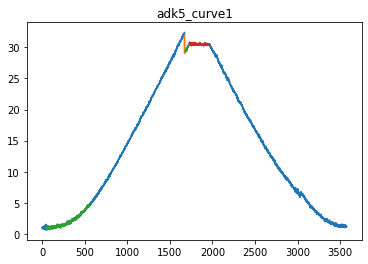

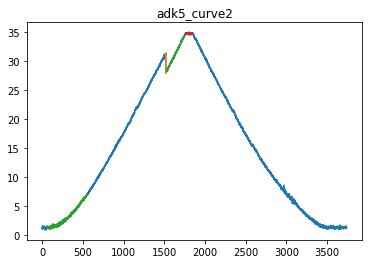

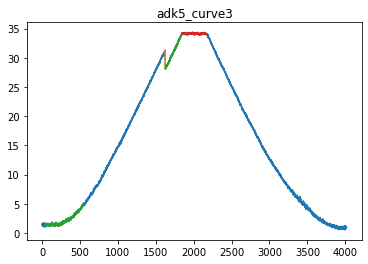

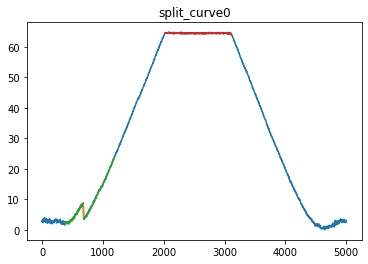

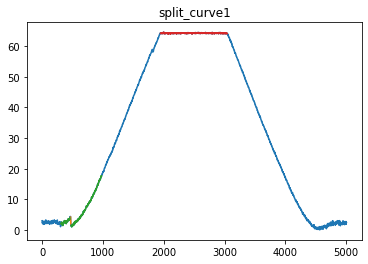

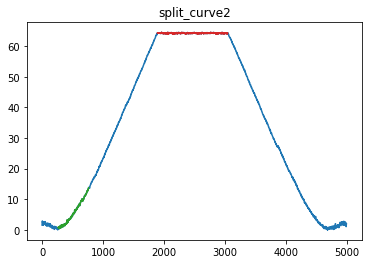

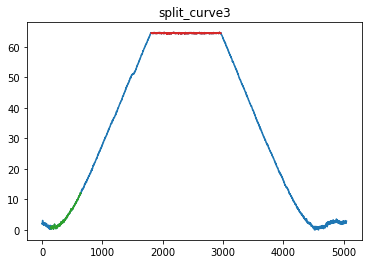

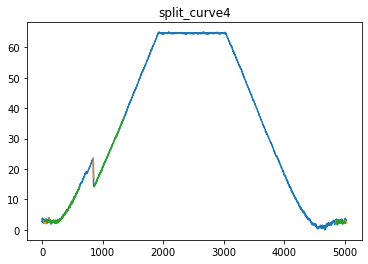

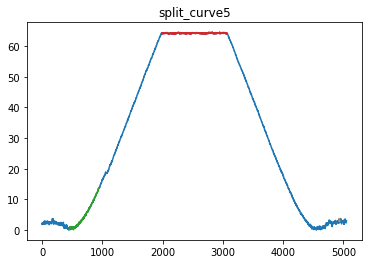

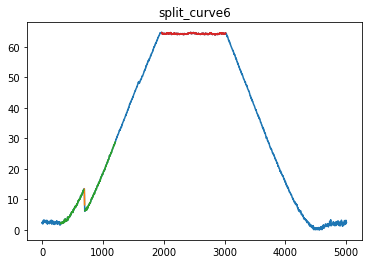

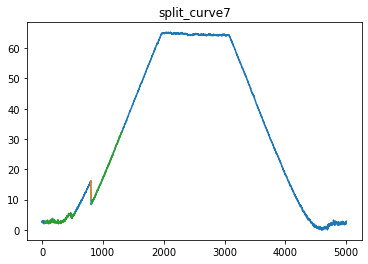

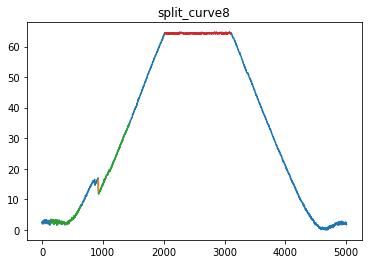

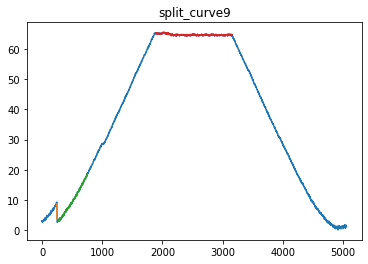

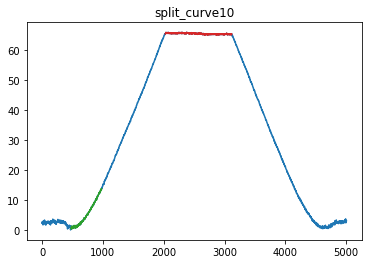

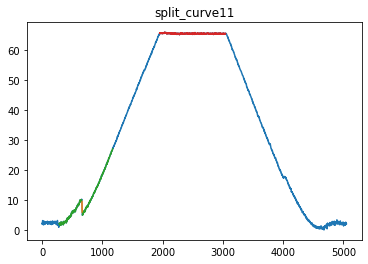

In [10]:
SHOW_PLOTS = True
%matplotlib inline

for curve in fdcurves.values():
    print(curve.identifier)
    curve.find_events(DEBUG=True, LONGEST=500)
    if SHOW_PLOTS:
        curve.plot_events()
# plot force over time (or number of measurements)
# green: fitted leg, orange: unfold event, red: return/stationary point


In [11]:
no_unfolds = {}
for curve_id, curve in fdcurves.items():
    if not curve.unfolds.any(): #or not curve_id == 'split_curve9':
        no_unfolds[curve_id] = curve  
for curve_id in no_unfolds.keys():
    print(curve_id)
    fdcurves.pop(curve_id)

split_curve2
split_curve3
split_curve10


In [12]:
for curve_id, curve in fdcurves.items():
    print(curve_id)
    print(curve.top)

adk5_curve1
(1731, 1955)
adk5_curve2
(1764, 1846)
adk5_curve3
(1847, 2169)
split_curve0
(2023, 3108)
split_curve1
(1947, 3045)
split_curve4
(4304, 3030)
split_curve5
(1989, 3071)
split_curve6
(1968, 3020)
split_curve7
(4389, 3075)
split_curve8
(2016, 3106)
split_curve9
(1882, 3157)
split_curve11
(1953, 3047)


## Error-finding
##### Multiple tethers
We filter multiple tethers comparison of the model as given in the estimates, with exaggerated parameters or data. The tests we perform include:
- A doubled persistence length
- A halved contour length
- Halved force data
- Doubled distance data

These should in theory test the single-tether case against the double-tether case. For a greater number of tethers we assume a double-tether model would fit better than a single-tether one. We compare the resulting BICs to determine pass or fail. We also compute Bayes factors for relative likelihood comparisons, but those turn out rather extreme.

Doubling the persistence length yields false positives and does not seem to be a good way to approximate a double tether. Some higher factor would probably work but for now we can just ignore that test.

We may want to hide some of this code behind an import

Halving contour length appears functionally identical to doubling the distance data, so we can do away with one.

In [13]:
from copy import deepcopy

original = handle_estimates
double_Lp = deepcopy(original)
half_Lc = deepcopy(original)
double_Lp['handles/Lp']['value'] = original['handles/Lp']['value'] * 2
half_Lc['handles/Lc']['value'] = original['handles/Lc']['value'] / 2

test_estimates = {'original': original, 'double_Lp': double_Lp, 
                  'half_Lc': half_Lc, 'half_force': original,
                  'double_dist': original}

for curve in fdcurves.values():
    print(curve.identifier)
    curve.filter_tethers(build_handles_model(), test_estimates)

adk5_curve1
adk5_curve1 
 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'original': False, 'double_dist': False}
adk5_curve2
adk5_curve2 
 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'original': False, 'double_dist': False}
adk5_curve3
adk5_curve3 
 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'original': False, 'double_dist': False}
split_curve0
split_curve0 
 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'original': False, 'double_dist': False}
split_curve1
split_curve1 
 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'original': False, 'double_dist': False}
split_curve4
split_curve4 
 {'double_Lp': False, 'half_Lc': False, 'half_force': False, 'original': False, 'double_dist': False}
split_curve5
split_curve5 
 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'original': False, 'double_dist': False}
split_curve6
split_curve6 
 {'double_Lp': True, 'half_Lc': False, 'half_force': False, 'original': False, 'do

/home/kris/.pyenv/versions/3.8.6/envs/tweez-3.8.6/lib/python3.8/site-packages/lumicks/pylake/fitting/fit.py:525: RuntimeWarning: divide by zero encountered in log
  return k * np.log(self.n_residuals) - 2.0 * self.log_likelihood()


## Fitting

Here we fit our models. We first define fits for each unfolding event, and proliferate a single fit of the DNA handles parameters to each of them. After that, we fit the remaining protein parameters with the legs we defined before. The third cell draws plots and shows parameter summaries for each curve.

In [14]:
for curve in fdcurves.values():
    print(curve.identifier, curve.legs)

adk5_curve1 [slice(58, 558, None), slice(1681, 1721, None)]
adk5_curve2 [slice(59, 559, None), slice(1529, 1754, None)]
adk5_curve3 [slice(45, 545, None), slice(1633, 1837, None)]
split_curve0 [slice(385, 669, None), slice(689, 1189, None)]
split_curve1 [slice(314, 459, None), slice(479, 979, None)]
split_curve4 [slice(160, 23, None), slice(43, 60, None), slice(80, 108, None), slice(128, 628, None), slice(855, 1355, None), slice(4864, 5000, None), slice(5020, 4294, None)]
split_curve5 [slice(453, 953, None), slice(4945, 1979, None)]
split_curve6 [slice(305, 685, None), slice(705, 1205, None)]
split_curve7 [slice(45, 545, None), slice(811, 1311, None)]
split_curve8 [slice(136, 636, None), slice(933, 1433, None)]
split_curve9 [slice(265, 236, None), slice(256, 756, None)]
split_curve11 [slice(286, 652, None), slice(672, 1172, None)]


In [17]:
#fdcurves.pop('split_curve4')
#fdcurves.pop('split_curve9')
fdcurves.pop('split_curve5')


for curve in fdcurves.values():
    print(curve.identifier)
    curve.initialize_fits(build_handles_model(),
                         build_composite_model(),
                         handle_estimates)

adk5_curve1
adk5_curve2
adk5_curve3
split_curve0
split_curve1
split_curve6
split_curve7
split_curve8
split_curve11


In [18]:
for curve_id, curve in fdcurves.items():
    print(curve_id)
    curve.fit_composites(protein_estimates)

adk5_curve1
adk5_curve2
adk5_curve3
split_curve0
split_curve1
split_curve6
split_curve7
split_curve8
split_curve11


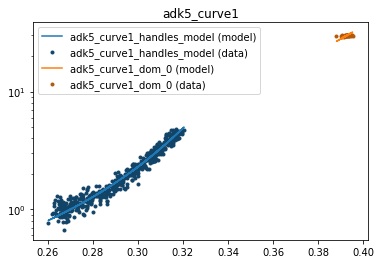

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         18.052      [nm]      False               0              100
handles/Lc          0.353619   [micron]  False               0              inf
handles/St        380.576      [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          0.6        [nm]      True                0.6              1
protein/Lc          0.0356574  [micron]  True                0              inf


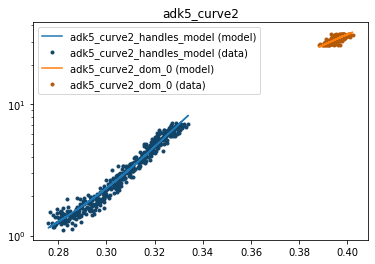

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         18.7079     [nm]      False               0              100
handles/Lc          0.351021   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          0.6        [nm]      True                0.6              1
protein/Lc          0.0197379  [micron]  True                0              inf


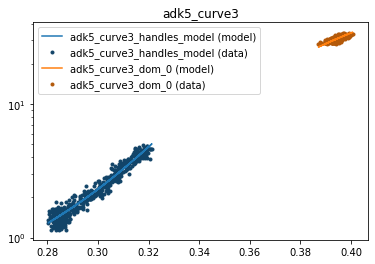

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp         18.8226     [nm]      False               0              100
handles/Lc          0.350767   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          0.6        [nm]      True                0.6              1
protein/Lc          0.0199683  [micron]  True                0              inf


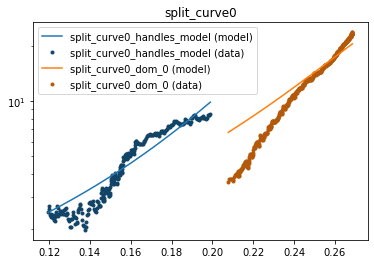

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp          1.37591    [nm]      False               0              100
handles/Lc          0.260373   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          1          [nm]      True                0.6              1
protein/Lc          0.0477619  [micron]  True                0              inf


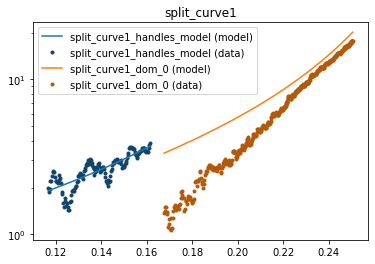

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp        1.61966      [nm]      False               0              100
handles/Lc        0.275642     [micron]  False               0              inf
handles/St        6.26251e+06  [pN]      False             250              inf
kT                4.11         [pN*nm]   False               0                8
handles/f_offset  0            [pN]      False              -6                6
protein/Lp        1            [nm]      True                0.6              1
protein/Lc        0.031317     [micron]  True                0              inf


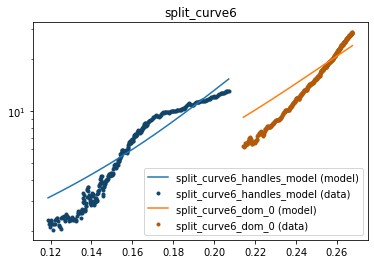

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp          1.10591    [nm]      False               0              100
handles/Lc          0.253863   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          1          [nm]      True                0.6              1
protein/Lc          0.0499938  [micron]  True                0              inf


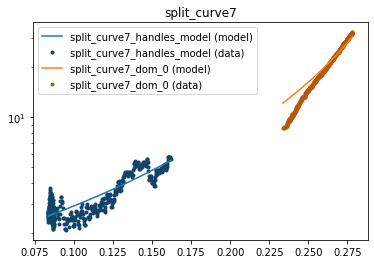

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp        0.728627     [nm]      False               0              100
handles/Lc        0.328628     [micron]  False               0              inf
handles/St        7.54407e+06  [pN]      False             250              inf
kT                4.11         [pN*nm]   False               0                8
handles/f_offset  0            [pN]      False              -6                6
protein/Lp        1            [nm]      True                0.6              1
protein/Lc        0.0248974    [micron]  True                0              inf


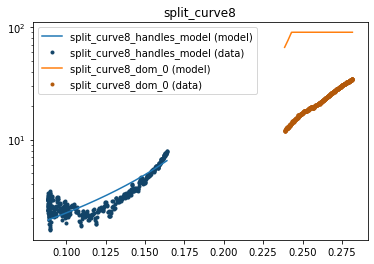

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp        1.25036      [nm]      False               0              100
handles/Lc        0.254329     [micron]  False               0              inf
handles/St        2.23993e+08  [pN]      False             250              inf
kT                4.11         [pN*nm]   False               0                8
handles/f_offset  0            [pN]      False              -6                6
protein/Lp        0.700001     [nm]      True                0.6              1
protein/Lc        0.0149474    [micron]  True                0              inf


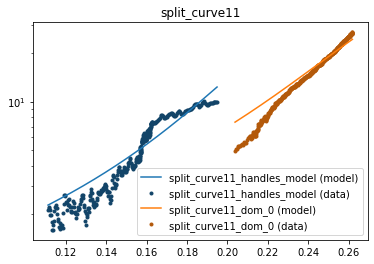

Name                    Value  Unit      Fitted      Lower bound    Upper bound
----------------  -----------  --------  --------  -------------  -------------
handles/Lp          1.52879    [nm]      False               0              100
handles/Lc          0.238751   [micron]  False               0              inf
handles/St        250          [pN]      False             250              inf
kT                  4.11       [pN*nm]   False               0                8
handles/f_offset    0          [pN]      False              -6                6
protein/Lp          1          [nm]      True                0.6              1
protein/Lc          0.0500459  [micron]  True                0              inf


In [19]:
%matplotlib inline
for curve in fdcurves.values():
    curve.plot_fits()
    plt.show()
    curve.print_fit_params()

#### Computing unfolding forces
We compute the force for each unfolding event by simulating the fitted model to the distance slightly before the unfolding event. This part is lacking an error estimation.

In [ ]:
for curve in fdcurves.values():
    curve.compute_unfold_forces(build_handles_model(), build_composite_model())

#### Result summary table
Prints a summary table containing fitted contour length, persistence length and unfolding force for each unfolding domain. Could be prettier

In [ ]:
# make a format string for the column widths
largest_id_len = max([len(id) for id in fdcurves.keys()])
row_format = f'{{:<{largest_id_len + 1}}}| {{:<5}}| {{:<9}}| {{:<9}}| {{:<9}}| {{}}'

print(row_format.format('Curve', 'fold', 'Lc (um)', 'Lp (nm)', 'Fu (pN)',
                        'failed tests'))
for curve_id, curve in fdcurves.items():
    curve.print_result_rows(row_format)

if lost_bead_fdcurves:
    print('\nBead losses for curves', [curve_id for curve_id in
                                       lost_bead_fdcurves.keys()])

In [19]:
from event_finding import moving_window_SLR

In [20]:
models = moving_window_SLR(fdcurves['split_curve9'].force_data)

In [21]:
models

[{'slope': array([0.01971299]),
  'intercept': 2.665269585490056,
  'score': 0.8720472098693561}]